> The following cookbook is an adaption of the original [LangGraph cookbook](https://github.com/langchain-ai/langgraph/blob/e3ca7bb3e9d34b09633852f4d08d55f6dcd4364b/examples/rag/langgraph_self_rag.ipynb)



# LangGraph Agents Powered by Pathway: A Complete Guide

This notebook demonstrates how to use Pathway VectorStore as a LangChain Retriever to power LangGraph Agents that are synced with your documents.

In this notebook, you will learn:
- How to build a Pathway vector store that indexes documents from your data sources
- How to create a vector index that enables semantic search through your documents
- How to use the Pathway LangChain Retriever in a LangGraph Agent

Magic library is used for detecting file types in the `UnstructuredParser` module.

If you are running this notebook on **MacOS**, you can install it with:
> `brew install libmagic`

If you are running the notebook on **colab** or any **linux** environment, you can install it with:
> `apt-get install libmagic1`

# Setup

Install the required packages and set your OpenAI API key. 
OpenAI is used for embeddings during the indexing stage and to power the LangGraph agent.

In [ ]:
!pip install -U "pathway[all]"

In [ ]:
!pip install -U langgraph langchain-community langchainhub langchain-openai

In [ ]:
import os

import json
from typing import Iterable, Literal, List
from pydantic import BaseModel, Field

# needed for the OpenAI embedder and the LLM we will use below, you can change the embedding provider, see the documentation:
# https://pathway.com/developers/api-docs/pathway-xpacks-llm/embedders
os.environ["OPENAI_API_KEY"] = "sk-..."

Lets define a `DATA_PATH` folder that will store the text files/documents for indexing.

In [ ]:
# folder that we will gather our docs in
DATA_PATH = "./data"

os.makedirs(DATA_PATH, exist_ok=True)

## Load & save a webpage

Define utility functions to read content from a webpage and save it locally into `DATA_PATH`.
  1. `load_page_content`: Reads the raw text from a webpage using using a `WebBaseLoader` from `langchain_community.document_loaders`.
  2.  `ingest_webpage`: Saves the loaded content as a text file into the `DATA_PATH`. 

In [ ]:
import re
from urllib.parse import urlparse
from langchain_community.document_loaders import WebBaseLoader


def load_page_content(url: str) -> str:
    """Load web page content with Langchain utilities."""
    return WebBaseLoader(url).load()[0].page_content


def ingest_webpage(url: str) -> None:
    """Save a webpage to local `DATA_PATH` folder."""
    text_content = load_page_content(url)

    parsed_url = urlparse(url)
    file_name = parsed_url.hostname + parsed_url.path.replace("/", "_") + ".txt"

    with open(os.path.join(DATA_PATH, file_name), "w", encoding="utf-8") as f:
        f.write(text_content)

Download the Self-RAG paper

In [ ]:
ingest_webpage("https://arxiv.org/html/2310.11511")

# Build the Pathway indexing pipeline

Set up Pathway to read and index the documents saved under the `DATA_PATH`.


1. [Connectors](https://pathway.com/developers/user-guide/connect/pathway-connectors): Use Pathway’s file reader to ingest all text files under the `DATA_PATH`.
2. [Parsers](https://pathway.com/developers/api-docs/pathway-xpacks-llm/parsers): Utilize the UnstructuredParser to parse the documents. This parser supports multiple file types, including PDF, DOCX, and PPTX.
3. [Text Splitters](https://pathway.com/developers/api-docs/pathway-xpacks-llm/splitters): Split the document content into chunks.
4. [Embedders](https://pathway.com/developers/api-docs/pathway-xpacks-llm/embedders): Use OpenAI API for embeddings.
5. [VectorStore](https://pathway.com/developers/api-docs/pathway-xpacks-llm/vectorstore): Orchestrates all the above modules.

In [ ]:
# host and port of the RAG app
pathway_host: str = "0.0.0.0"
pathway_port: int = 8000

Create the vector store that will power the index of our RAG application. 

We use the modules under the Pathway Xpacks to create a suitable vector store.

In [ ]:
import pathway as pw

from pathway.xpacks.llm.vector_store import VectorStoreServer, VectorStoreClient
from pathway.xpacks.llm import (
    embedders,
    llms,
    parsers,
    splitters,
)
from pathway.udfs import DiskCache

# read the text files under the data folder, we can also read from Google Drive, Sharepoint, etc.
# See connectors documentation: https://pathway.com/developers/user-guide/connect/pathway-connectors to learn more
folder = pw.io.fs.read(
    path=f"{DATA_PATH}/*.txt",
    format="binary",
    with_metadata=True,
)

# list of data sources to be indexed
sources = [folder]

# define the document processing steps
parser = parsers.UnstructuredParser()

text_splitter = splitters.TokenCountSplitter(min_tokens=150, max_tokens=450)

embedder = embedders.OpenAIEmbedder(cache_strategy=DiskCache())

vector_server = VectorStoreServer(
    *sources,
    embedder=embedder,
    splitter=text_splitter,
    parser=parser,
)

# deploy the vector store locally
t = vector_server.run_server(pathway_host, pathway_port, threaded=True)

[VectorStore](https://pathway.com/developers/api-docs/pathway-xpacks-llm/vectorstore) manages document ingestion, parsing, splitting, and indexing.

List the indexed documents

In [ ]:
pathway_client = VectorStoreClient(pathway_host, pathway_port)

In [ ]:
pathway_client.get_input_files()

# Create the LangGraph agent

### Create the Langchain Retriever

You can now query Pathway and access up-to-date documents for your RAG applications from LangChain using [PathwayVectorClient](https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.pathway.PathwayVectorClient.html)

The Langchain Retriever is a wrapper around the Pathway client, you will use it in `retrieve` part stage of the Agent

In [ ]:
from langchain_community.vectorstores import PathwayVectorClient

In [ ]:
vectorstore_client = PathwayVectorClient(pathway_host, pathway_port)

In [ ]:
retriever = vectorstore_client.as_retriever()

In [ ]:
# test the retriever
# retriever.invoke({"question": "evaluation"})

### Self-RAG

Self-RAG is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents and generations.

In the [paper](https://arxiv.org/abs/2310.11511), a few decisions are made:

1. Should I retrieve from retriever, `R` -

* Input: `x (question)` OR `x (question)`, `y (generation)`
* Decides when to retrieve `D` chunks with `R`
* Output: `yes, no, continue`

2. Are the retrieved passages `D` relevant to the question `x` -

* * Input: (`x (question)`, `d (chunk)`) for `d` in `D`
* `d` provides useful information to solve `x`
* Output: `relevant, irrelevant`

3. Are the LLM generation from each chunk in `D` is relevant to the chunk (hallucinations, etc)  -

* Input: `x (question)`, `d (chunk)`,  `y (generation)` for `d` in `D`
* All of the verification-worthy statements in `y (generation)` are supported by `d`
* Output: `{fully supported, partially supported, no support`

4. The LLM generation from each chunk in `D` is a useful response to `x (question)` -

* Input: `x (question)`, `y (generation)` for `d` in `D`
* `y (generation)` is a useful response to `x (question)`.
* Output: `{5, 4, 3, 2, 1}`

We will implement some of these ideas from scratch using [LangGraph](https://langchain-ai.github.io/langgraph/).
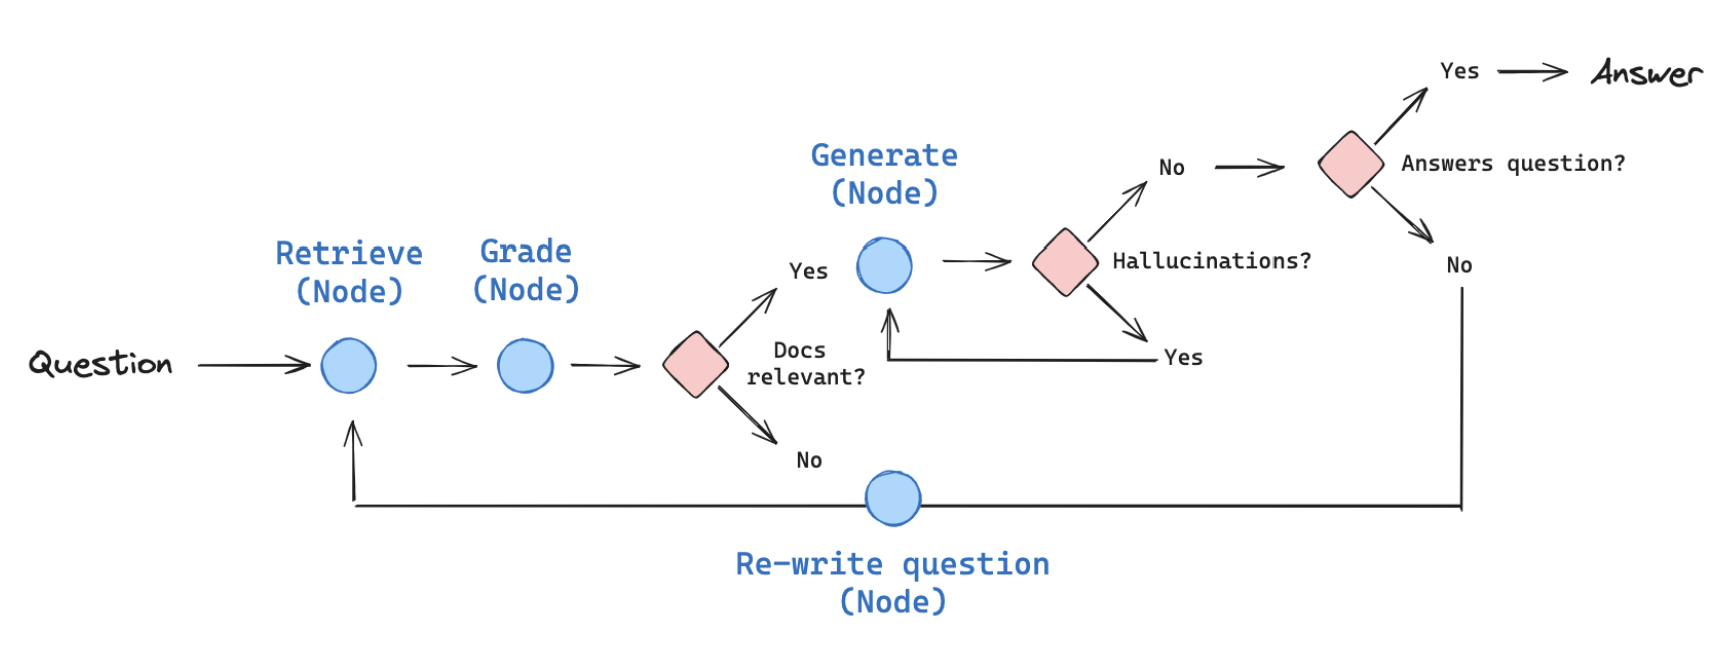
> Figure and the explanation taken from the [LangGraph cookbook](https://github.com/langchain-ai/langgraph/blob/e3ca7bb3e9d34b09633852f4d08d55f6dcd4364b/examples/rag/langgraph_self_rag.ipynb)

### Define the LangGraph Workflow


The LangGraph agent operates as a multi-step workflow.

- It retrieves documents, grades their relevance, generates an answer, and ensures factual accuracy (e.g., no hallucinations).
- You can also implement self-reflection and query optimization using LangGraph nodes.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader


question = "self rag performance"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

In [ ]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

In [ ]:
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

In [ ]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [ ]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### Compose the graph

In [ ]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

# Run with a sample question

Test the `/agent` endpoint by sending a sample question. The server runs the entire RAG pipeline and returns the answer.

In [ ]:
inputs = {
    "question": "How does self-RAG work? Explain the steps involved in the implementation."
}

In [ ]:
result = app.invoke(inputs)

In [ ]:
result["generation"]